# **Import Google Drive**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Setting**


In [2]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set the text properties to use LaTeX fonts
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 28
plt.rcParams['figure.figsize'] = (5,5)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch


# **Discrete Gaussian**

This is the discrete Gaussian sampler
See the paper https://arxiv.org/abs/2004.00010
Now running some basic testing code
Start by calculating normalizing constant and variance for different values
sigma^2=1.0000000000000056e-100:	norm_const=1.0=sqrt{2*pi}*sigma*3.9894228040143154e+49	var=0.0
sigma^2=1.0000000000000004e-06:	norm_const=1.0=sqrt{2*pi}*sigma*398.9422804014326	var=0.0
sigma^2=0.001:	norm_const=1.0=sqrt{2*pi}*sigma*12.6156626101008	var=1.4249152813482571e-217
sigma^2=0.01:	norm_const=1.0=sqrt{2*pi}*sigma*3.989422804014327	var=1.9287498479639178e-22
sigma^2=0.03:	norm_const=1.0000001155549705=sqrt{2*pi}*sigma*2.3032945959660114	var=1.1555495703925331e-07
sigma^2=0.05:	norm_const=1.000090799859525=sqrt{2*pi}*sigma*1.7842861143718929	var=9.07916156590598e-05
sigma^2=0.08:	norm_const=1.0038609083002312=sqrt{2*pi}*sigma*1.4159196694844496	var=0.0038460591020486826
sigma^2=0.1:	norm_const=1.0134758981204781=sqrt{2*pi}*sigma*1.2785669994156845	var=0.013296725173624149
sigma^2=0.15:

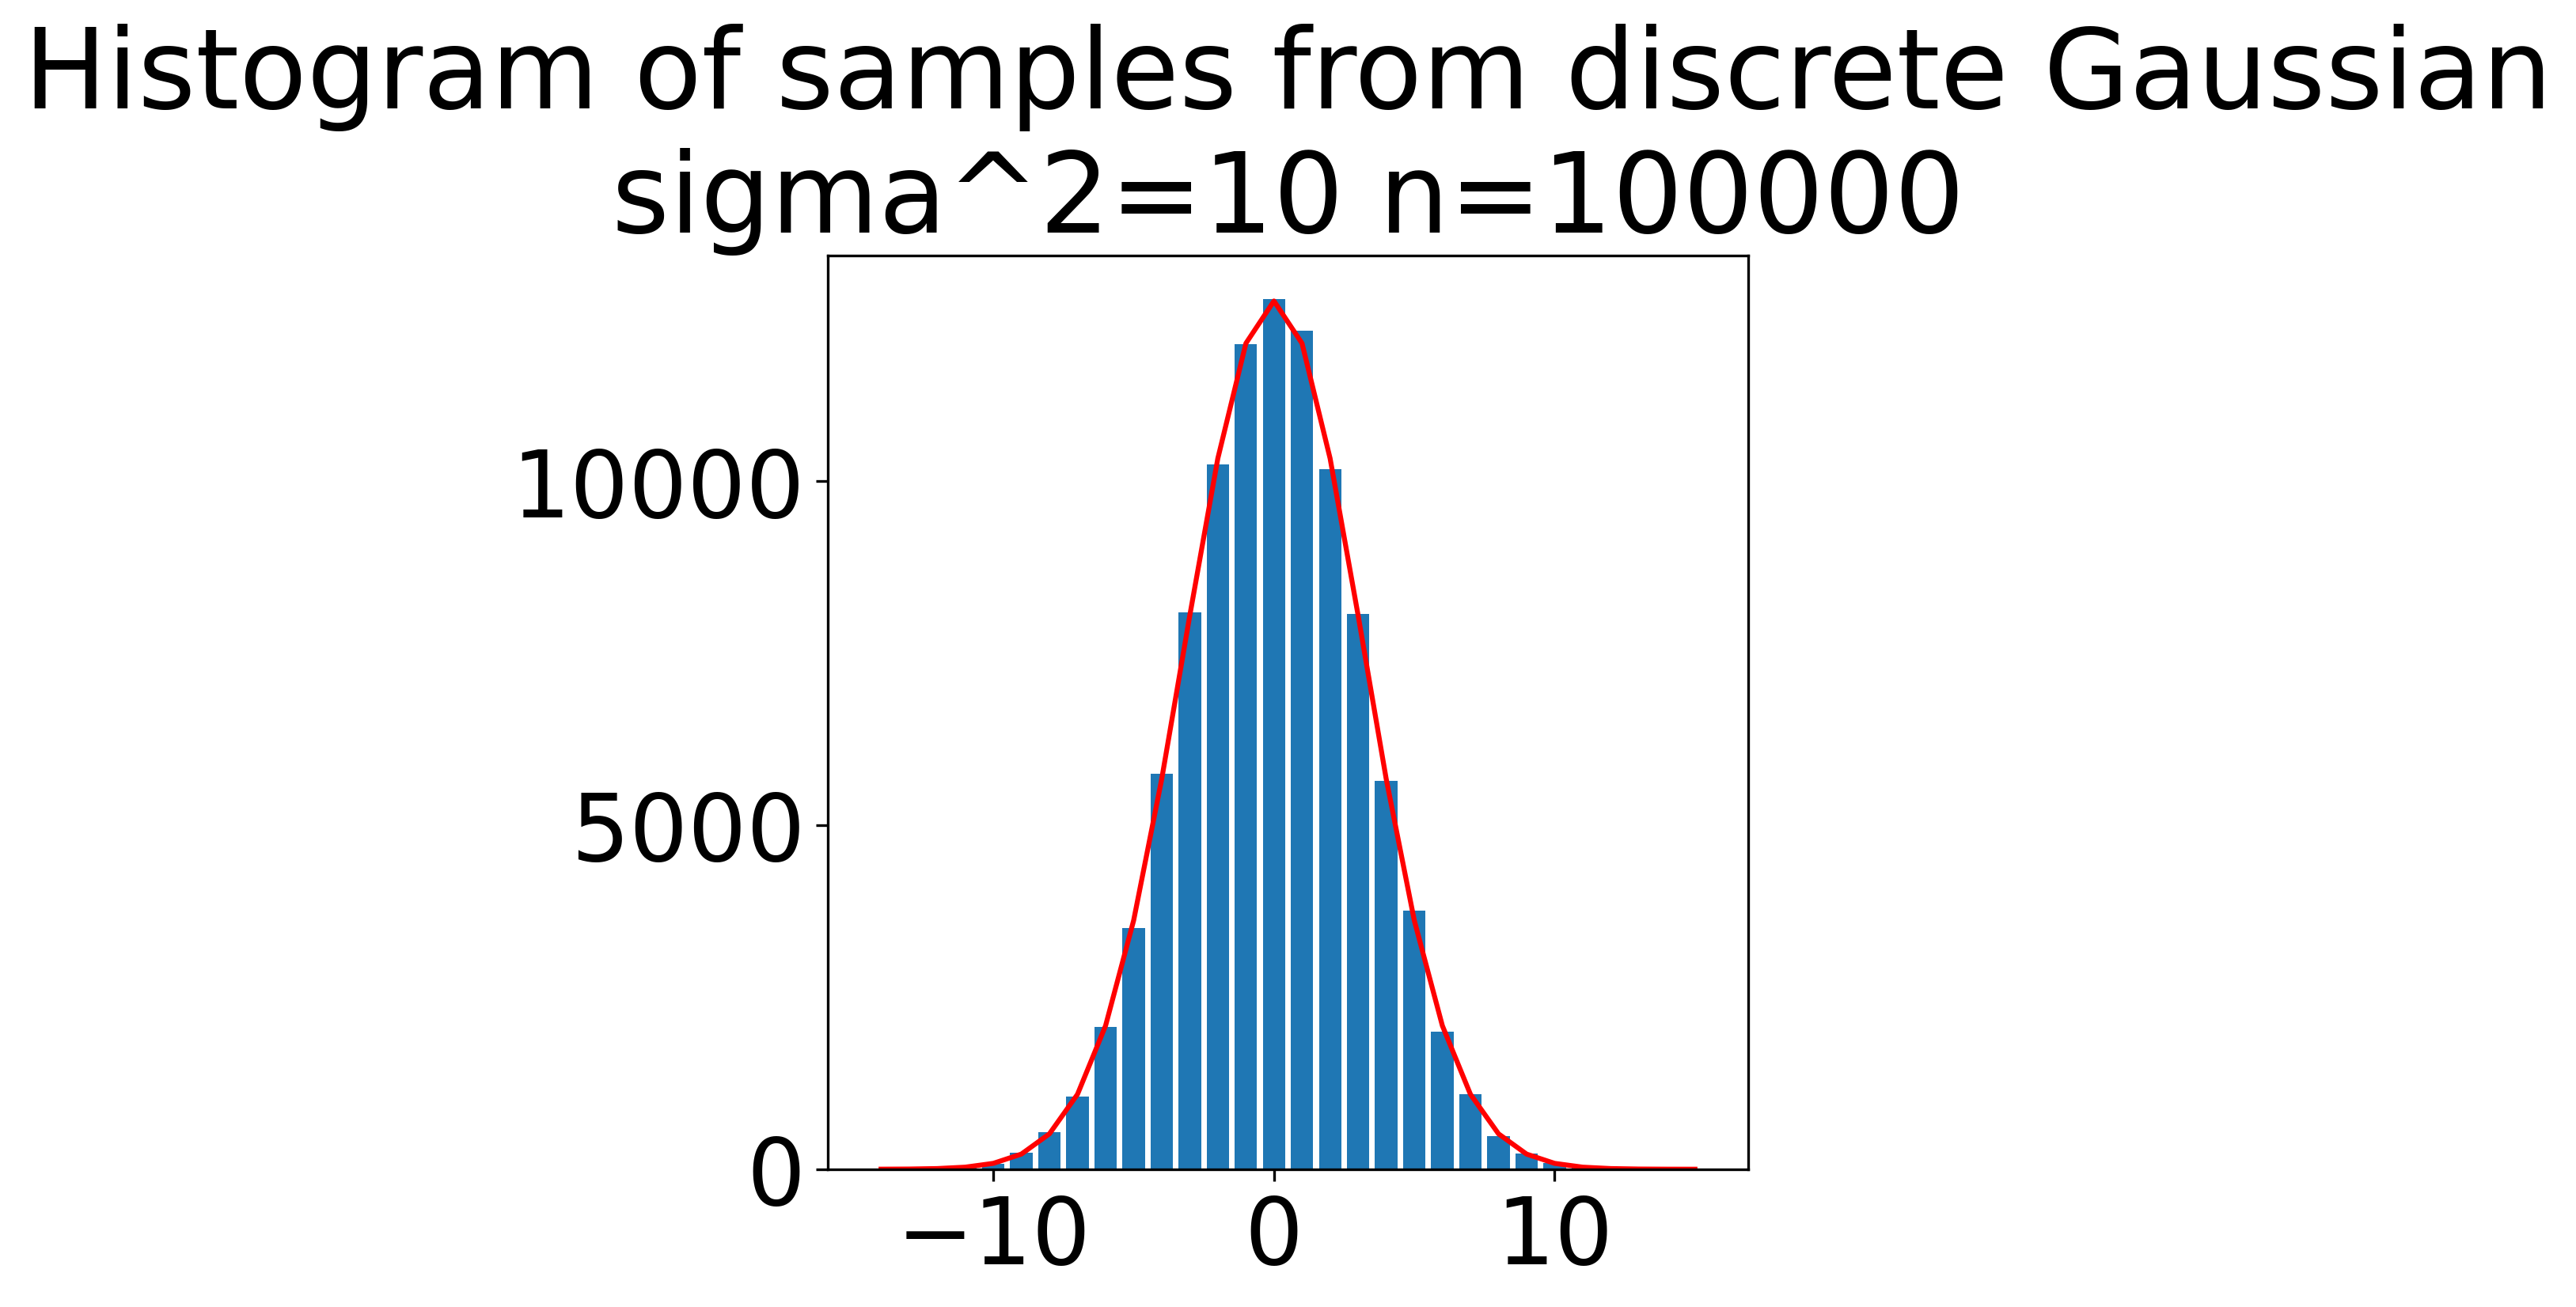

<Figure size 1500x1500 with 0 Axes>

In [3]:
# Implementation of exact discrete gaussian distribution sampler
# See https://arxiv.org/abs/2004.00010
# - Thomas Steinke dgauss@thomas-steinke.net 2020

import random #Default random number generator,
#random.SecureRandom() provides high-quality randomness from /dev/urandom or similar
from fractions import Fraction #we will work with rational numbers

#sample uniformly from range(m)
#all randomness comes from calling this
def sample_uniform(m,rng):
    assert isinstance(m,int) #python 3
    #assert isinstance(m,(int,long)) #python 2
    assert m>0
    return rng.randrange(m)

#sample from a Bernoulli(p) distribution
#assumes p is a rational number in [0,1]
def sample_bernoulli(p,rng):
    assert isinstance(p,Fraction)
    assert 0 <= p <= 1
    m=sample_uniform(p.denominator,rng)
    if m < p.numerator:
        return 1
    else:
        return 0

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number in [0,1]
def sample_bernoulli_exp1(x,rng):
    assert isinstance(x,Fraction)
    assert 0 <= x <= 1
    k=1
    while True:
        if sample_bernoulli(x/k,rng)==1:
            k=k+1
        else:
            break
    return k%2

#sample from a Bernoulli(exp(-x)) distribution
#assumes x is a rational number >=0
def sample_bernoulli_exp(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    #Sample floor(x) independent Bernoulli(exp(-1))
    #If all are 1, return Bernoulli(exp(-(x-floor(x))))
    while x>1:
        if sample_bernoulli_exp1(Fraction(1,1),rng)==1:
            x=x-1
        else:
            return 0
    return sample_bernoulli_exp1(x,rng)

#sample from a geometric(1-exp(-x)) distribution
#assumes x is a rational number >= 0
def sample_geometric_exp_slow(x,rng):
    assert isinstance(x,Fraction)
    assert x >= 0
    k=0
    while True:
        if sample_bernoulli_exp(x,rng)==1:
            k=k+1
        else:
            return k

#sample from a geometric(1-exp(-x)) distribution
#assumes x >= 0 rational
def sample_geometric_exp_fast(x,rng):
    assert isinstance(x,Fraction)
    if x==0: return 0 #degenerate case
    assert x>0

    t=x.denominator
    while True:
        u=sample_uniform(t,rng)
        b=sample_bernoulli_exp(Fraction(u,t),rng)
        if b==1:
            break
    v=sample_geometric_exp_slow(Fraction(1,1),rng)
    value = v*t+u
    return value//x.numerator

#sample from a discrete Laplace(scale) distribution
#Returns integer x with Pr[x] = exp(-abs(x)/scale)*(exp(1/scale)-1)/(exp(1/scale)+1)
#casts scale to Fraction
#assumes scale>=0
def sample_dlaplace(scale,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    scale = Fraction(scale)
    assert scale >= 0
    while True:
        sign=sample_bernoulli(Fraction(1,2),rng)
        magnitude=sample_geometric_exp_fast(1/scale,rng)
        if sign==1 and magnitude==0: continue
        return magnitude*(1-2*sign)

#compute floor(sqrt(x)) exactly
#only requires comparisons between x and integer
def floorsqrt(x):
    assert x >= 0
    #a,b integers
    a=0 #maintain a^2<=x
    b=1 #maintain b^2>x
    while b*b <= x:
        b=2*b #double to get upper bound
    #now do binary search
    while a+1<b:
        c=(a+b)//2 #c=floor((a+b)/2)
        if c*c <= x:
            a=c
        else:
            b=c
    #check nothing funky happened
    #assert isinstance(a,int) #python 3
    #assert isinstance(a,(int,long)) #python 2
    return a

#sample from a discrete Gaussian distribution N_Z(0,sigma2)
#Returns integer x with Pr[x] = exp(-x^2/(2*sigma2))/normalizing_constant(sigma2)
#mean 0 variance ~= sigma2 for large sigma2
#casts sigma2 to Fraction
#assumes sigma2>=0
def sample_dgauss(sigma2,rng=None):
    if rng is None:
        rng = random.SystemRandom()
    sigma2=Fraction(sigma2)
    if sigma2==0: return 0 #degenerate case
    assert sigma2 > 0
    t = floorsqrt(sigma2)+1
    while True:
        candidate = sample_dlaplace(t,rng=rng)
        bias=((abs(candidate)-sigma2/t)**2)/(2*sigma2)
        if sample_bernoulli_exp(bias,rng)==1:
            return candidate

#########################################################################
#DONE That's it! Now some utilities

import math #need this, code below is no longer exact

#Compute the normalizing constant of the discrete gaussian
#i.e. sum_{x in Z} exp(-x^2/2sigma2)
#By Poisson summation formula, this is equivalent to
# sqrt{2*pi*sigma2}*sum_{y in Z} exp(-2*pi^2*sigma2*y^2)
#For small sigma2 the former converges faster
#For large sigma2, the latter converges faster
#crossover at sigma2=1/2*pi
#For intermediate sigma2, this code will compute both and check
def normalizing_constant(sigma2):
    original=None
    poisson=None
    if sigma2<=1:
        original = 0
        x=1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0:
            original = original + math.exp(-x*x/(2.0*sigma2))
            x = x - 1 #sum from small to large for improved accuracy
        original = 2*original + 1 #symmetrize and add x=0
    if sigma2*100 >= 1:
        poisson = 0
        y = 1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0:
            poisson = poisson + math.exp(-math.pi*math.pi*sigma2*2*y*y)
            y = y - 1 #sum from small to large
        poisson = math.sqrt(2*math.pi*sigma2)*(1+2*poisson)
    if poisson is None: return original
    if original is None: return poisson
    #if we have computed both, check equality
    scale = max(1,math.sqrt(2*math.pi*sigma2)) #tight-ish lower bound on constant
    assert -1e-15*scale <= original-poisson <= 1e-15*scale
    #10^-15 is about as much precision as we can expect from double precision floating point numbers
    #64-bit float has 56-bit mantissa 10^-15 ~= 2^-50
    return (original+poisson)/2

#compute the variance of discrete gaussian
#mean is zero, thus:
#var = sum_{x in Z} x^2*exp(-x^2/(2*sigma2)) / normalizing_constant(sigma2)
#By Poisson summation formula, we have equivalent expression:
# variance(sigma2) = sigma2 * (1 - 4*pi^2*sigma2*variance(1/(4*pi^2*sigma2)) )
#See lemma 20 https://arxiv.org/pdf/2004.00010v3.pdf#page=17
#alternative expression converges faster when sigma2 is large
#crossover point (in terms of convergence) is sigma2=1/(2*pi)
#for intermediate values of sigma2, we compute both expressions and check
def variance(sigma2):
    original=None
    poisson=None
    if sigma2<=1: #compute primary expression
        original=0
        x = 1000 #summation stops at exp(-x^2/2sigma2)<=exp(-500,000)
        while x>0: #sum from small to large for improved accuracy
            original = original + x*x*math.exp(-x*x/(2.0*sigma2))
            x=x-1
        original = 2*original/normalizing_constant(sigma2)
    if sigma2*100>=1:
        poisson=0 #we will compute sum_{y in Z} y^2 * exp(-2*pi^2*sigma2*y^2)
        y=1000 #summation stops at exp(-y^2*2*pi^2*sigma2)<=exp(-190,000)
        while y>0: #sum from small to large
            poisson = poisson + y*y*math.exp(-y*y*2*sigma2*math.pi*math.pi)
            y=y-1
        poisson = 2*poisson/normalizing_constant(1/(4*sigma2*math.pi*math.pi))
        #next convert from variance(1/(4*pi^2*sigma2)) to variance(sigma2)
        poisson = sigma2*(1-4*sigma2*poisson*math.pi*math.pi)
    if original is None: return poisson
    if poisson is None: return original
    #if we have computed both check equality
    assert -1e-15*sigma2 <= original-poisson <= 1e-15*sigma2
    return (original+poisson)/2

#########################################################################
#DONE Now some basic testing code

import matplotlib.pyplot as plt #only needed for testing
import time #only needed for testing

#This generates n samples from sample_dgauss(sigma2)
#It times this and releases statistics
#produces a histogram plot if plot==True
#if plot==None it will only produce a histogram if it's not too large
#can save image instead of displaying by specifying a path  e.g., save="plot.png"
def plot_histogram(sigma2,n,save=None,plot=None):
    #generate samples
    before=time.time()
    samples = [sample_dgauss(sigma2) for i in range(n)]
    after=time.time()
    print("generated "+str(n)+" samples in "+str(after-before)+" seconds ("+str(n/(after-before))+" samples per second) for sigma^2="+str(sigma2))
    #now process
    samples.sort()
    values=[]
    counts=[]
    counter=None
    prev=None
    for sample in samples:
        if prev is None: #initializing
            prev=sample
            counter=1
        elif sample==prev: #still same element
            counter=counter+1
        else:
            #add prev to histogram
            values.append(prev)
            counts.append(counter)
            #start counting
            prev=sample
            counter=1
    #add final value
    values.append(prev)
    counts.append(counter)

    #print & sum
    sum=0
    sumsquared=0
    kl=0 #compute KL divergence betwen empirical distribution and true distribution
    norm_const=normalizing_constant(sigma2)
    true_var=variance(sigma2)
    for i in range(len(values)):
        if len(values)<=100: #don't print too much
            print(str(values[i])+":\t"+str(counts[i]))
        sum = sum + values[i]*counts[i]
        sumsquared = sumsquared + values[i]*values[i]*counts[i]
        kl = kl + counts[i]*(math.log(counts[i]*norm_const/n)+values[i]*values[i]/(2.0*sigma2))
    mean = Fraction(sum,n)
    var=Fraction(sumsquared,n)
    kl=kl/n
    print("mean="+str(float(mean))+" (true=0)")
    print("variance="+str(float(var))+" (true="+str(true_var)+")")
    print("KL(empirical||true)="+str(kl)) # https://en.wikipedia.org/wiki/G-test
    assert kl>0 #kl divergence always >=0 and ==0 iff empirical==true, which is impossible
    #now plot
    if plot is None:
        plot = (len(values)<=1000) #don't plot if huge
    if not plot: return
    ideal_counts = [n*math.exp(-x*x/(2.0*sigma2))/norm_const for x in values]
    plt.bar(values, counts)
    plt.plot(values, ideal_counts,'r')
    plt.title("Histogram of samples from discrete Gaussian\nsigma^2="+str(sigma2)+" n="+str(n))
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
    plt.clf()

if __name__ == '__main__':
    print("This is the discrete Gaussian sampler")
    print("See the paper https://arxiv.org/abs/2004.00010")
    print("Now running some basic testing code")
    print("Start by calculating normalizing constant and variance for different values")
    #some test code for normalizing_constant and variance functions
    for sigma2 in [0.1**100,0.1**6,0.001,0.01,0.03,0.05,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,10,100,10**6,10**20,10**100]:
        #internal asserts do some testing when 0.01<=sigma2<=1
        c=normalizing_constant(sigma2)
        v=variance(sigma2)
        #print
        print("sigma^2="+str(sigma2) + ":\tnorm_const=" + str(c) + "=sqrt{2*pi}*sigma*" + str(c/math.sqrt(2*math.pi*sigma2)) + "\tvar=" + str(v))
    #print a few samples
    #for i in range(20): print sample_dgauss(1)
    #plot histogram and statistics
    #includes timing
    print("Now run the sampler")
    print("Start with very large sigma^2=10^100 -- for timing purposes only")
    plot_histogram(10**100,100000,plot=False) #large var, this will just be for timing
    print("Now sigma^2=10 -- will display a histogram")
    plot_histogram(10,100000) #small var, this will produce plot



# **Load CSV file into a pandas DataFrame**


In [4]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county.csv', encoding='latin1')

# Step 2: Write the DataFrame to a new CSV file with UTF-8 encoding.
df.to_csv('/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_utf8.csv', index=False, encoding='utf-8')

df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_utf8.csv')

# **Cleaning Data**

## Delete all DP-Data

In [5]:
# Drop columns where the column name contains 'dp'
df = df.drop(columns=[col for col in df.columns if 'dp' in col])

print(df)

       gisjoin                 name  state  H72001_sf  H72002_sf  H72003_sf  \
0     G0100010       Autauga County      1      54571      53702      42855   
1     G0100030       Baldwin County      1     182265     179542     156153   
2     G0100050       Barbour County      1      27457      27199      13180   
3     G0100070          Bibb County      1      22915      22712      17381   
4     G0100090        Blount County      1      57322      56638      53068   
...        ...                  ...    ...        ...        ...        ...   
3216  G7201450  Vega Baja Municipio     72      59662      58219      46113   
3217  G7201470    Vieques Municipio     72       9301       8830       5456   
3218  G7201490   Villalba Municipio     72      26073      25319      21405   
3219  G7201510    Yabucoa Municipio     72      37941      34761      24888   
3220  G7201530      Yauco Municipio     72      42043      40896      34899   

      H72004_sf  H72005_sf  H72006_sf  H72007_sf  .

## Re-index all the county

In [6]:
# Add new index column starting from 1 for the second row to the last row
df['county_idx'] = range(1, len(df) + 1)

# Move New_Index to the first column
cols = ['county_idx'] + [col for col in df if col != 'county_idx']
df = df[cols]

print(df)
# Save the modified DataFrame back to a CSV file
df.to_csv('/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_cleaned.csv', index=False)

df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_cleaned.csv')


      county_idx   gisjoin                 name  state  H72001_sf  H72002_sf  \
0              1  G0100010       Autauga County      1      54571      53702   
1              2  G0100030       Baldwin County      1     182265     179542   
2              3  G0100050       Barbour County      1      27457      27199   
3              4  G0100070          Bibb County      1      22915      22712   
4              5  G0100090        Blount County      1      57322      56638   
...          ...       ...                  ...    ...        ...        ...   
3216        3217  G7201450  Vega Baja Municipio     72      59662      58219   
3217        3218  G7201470    Vieques Municipio     72       9301       8830   
3218        3219  G7201490   Villalba Municipio     72      26073      25319   
3219        3220  G7201510    Yabucoa Municipio     72      37941      34761   
3220        3221  G7201530      Yauco Municipio     72      42043      40896   

      H72003_sf  H72004_sf  H72005_sf  

# **Error and Plot**

In [7]:
df = df.iloc[0:, 4:]


df_matrix = df.to_numpy()
df_vector = df_matrix.flatten()
print(df_matrix.shape)
print(df_vector.shape)
df_vector = df_vector.tolist()



privatized_ans=[]
for i in range(len(df_vector)):
        sigma2_CLT = 13.21
        noise_CLT = sample_dgauss(sigma2_CLT)
        privatized_ans.append(df_vector[i] + noise_CLT)
print(privatized_ans)



privatized_ans = np.array(privatized_ans)
df_vector = np.array(df_vector)
error_CLT = privatized_ans - df_vector
error_CLT2 = np.square(error_CLT)
error_CLT_mean = np.mean(error_CLT2)
print("LS error for CLT is " + str(error_CLT_mean))



privatized_ans_zCDP=[]
for i in range(len(df_vector)):
        sigma2_zCDP = 16.07
        noise_zCDP = sample_dgauss(sigma2_zCDP)
        privatized_ans_zCDP.append(df_vector[i] + noise_zCDP)
print(privatized_ans)



privatized_ans_zCDP = np.array(privatized_ans_zCDP)
df_vector = np.array(df_vector)
error_zCDP = privatized_ans_zCDP - df_vector
error_zCDP2 = np.square(error_zCDP)
error_zCDP_mean = np.mean(error_zCDP2)
print("LS error for z-CDP is " + str(error_zCDP_mean))



(3221, 301)
(969521,)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[54571 53701 42855 ... 18019 15139  2884]
LS error for z-CDP is 16.09085930062371


## **Save**

In [8]:
df_privatized_ans = pd.DataFrame({
    'privatized_ans_CLT': privatized_ans,
    'privatized_ans_zCDP': privatized_ans_zCDP
})

# Save to CSV
csv_path = "/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_privatized_data.csv"
df_privatized_ans.to_csv(csv_path, index=False)

# **Plot**

### MSE

(3221, 301)
(969521,)


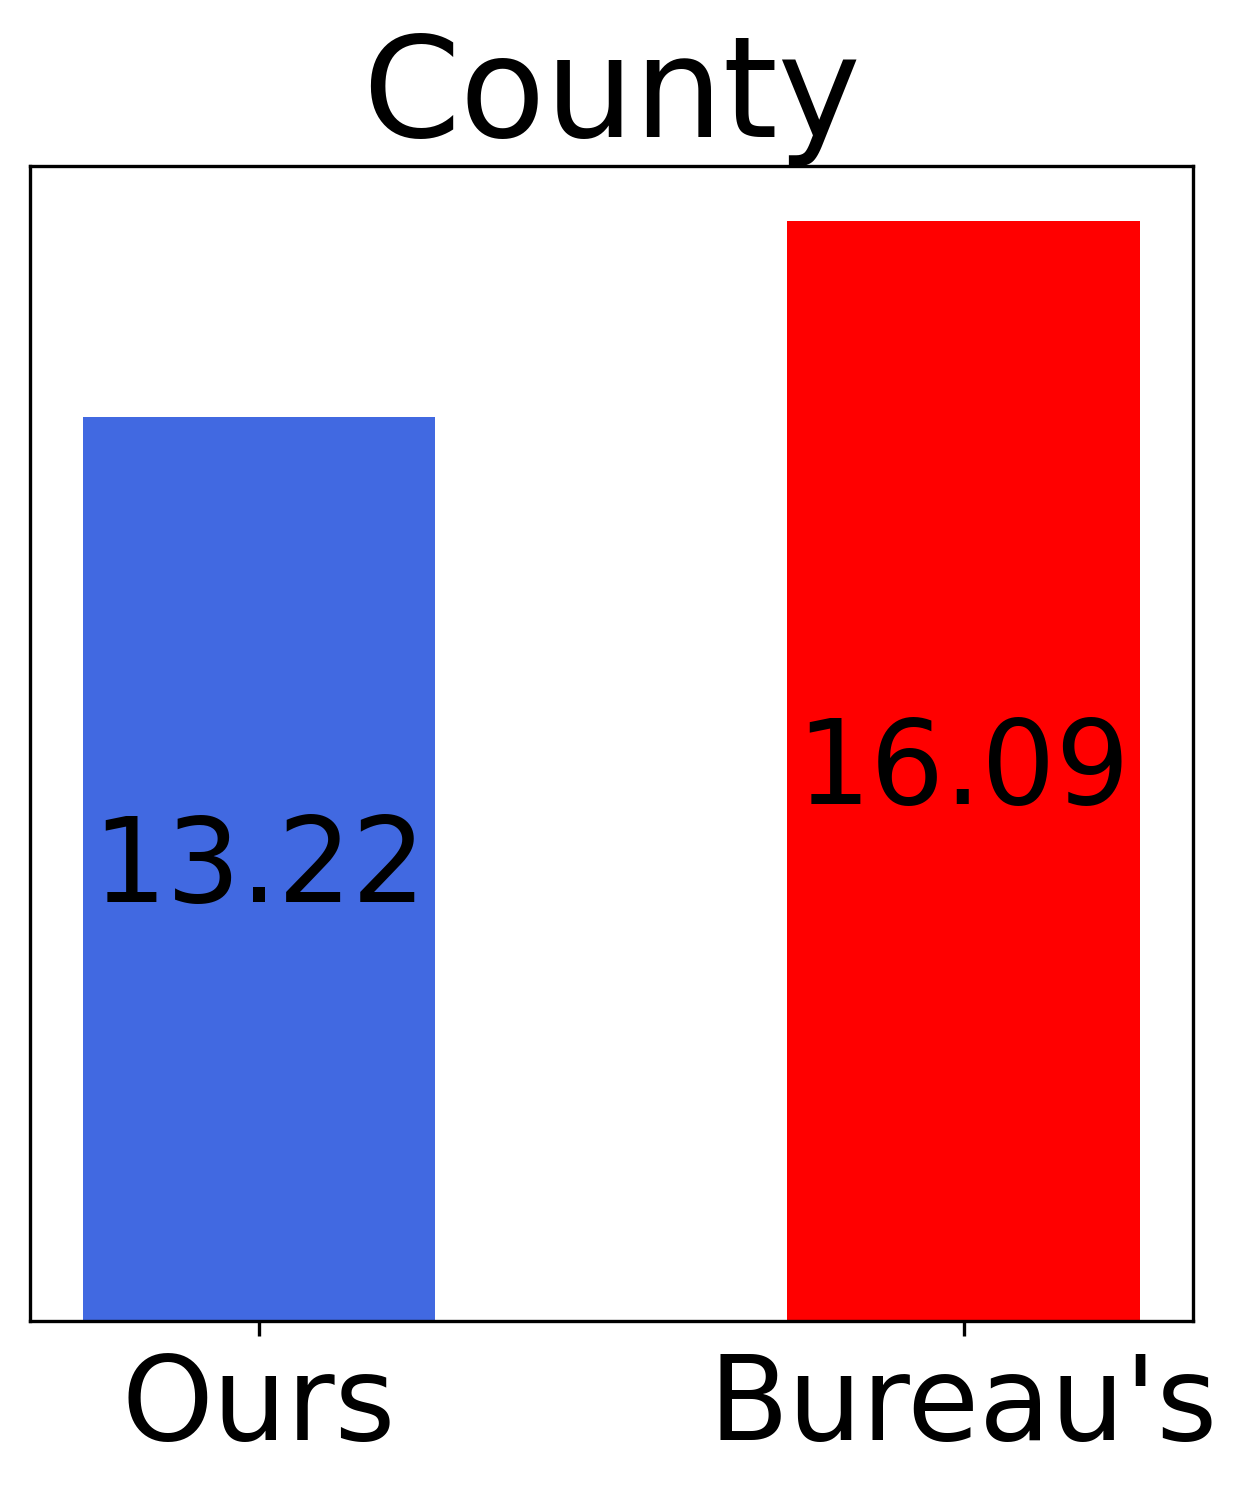

In [9]:
df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_cleaned.csv')
df = df.iloc[0:, 4:]


df_matrix = df.to_numpy()
df_vector = df_matrix.flatten()
print(df_matrix.shape)
print(df_vector.shape)
df_vector = df_vector.tolist()

data = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_privatized_data.csv')

privatized_ans = data['privatized_ans_CLT']
privatized_ans_zCDP = data['privatized_ans_zCDP']

error_CLT = privatized_ans - df_vector[:len(data)]
error_zCDP = privatized_ans_zCDP - df_vector[:len(data)]

list1 = np.square(error_CLT)
list2 = np.square(error_zCDP)

mean1 = np.mean(list1)
mean2 = np.mean(list2)
std1 = np.std(list1)
std2 = np.std(list2)

error_kw = {'capsize': 10, 'elinewidth': 2, 'capthick': 2}

# Confidence interval (95%) calculation
# Assuming a normal distribution, the confidence interval can be calculated as 1.96 * std/sqrt(n)
ci1 = 1.96 * (std1/np.sqrt(len(list1)))
ci2 = 1.96 * (std2/np.sqrt(len(list2)))


# Create figure and axis
fig, ax = plt.subplots()
x_positions = [0, 0.2]

# Bar plots
bars1 = ax.bar(x_positions[0], mean1, color='royalblue', error_kw=error_kw, width=0.1)
bars2 = ax.bar(x_positions[1], mean2, color='red', error_kw=error_kw, width=0.1)

# Adding the numbers on top of the bars
ax.bar_label(bars1, fmt='%.2f', label_type='center')
ax.bar_label(bars2, fmt='%.2f', label_type='center')

# Setting the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(['Ours', "Bureau's"])

# Remove Y-axis label and Y-axis ticks
ax.set_yticks([])
ax.set_ylabel('')


# ax.set_ylabel('Mean Squared Error')
ax.set_title('County')

# Show the plot
plt.savefig("/content/drive/MyDrive/American_Census_Data/Figures_V1/county_level_mse.svg", bbox_inches='tight')
plt.show()

### MAE

(3221, 301)
(969521,)


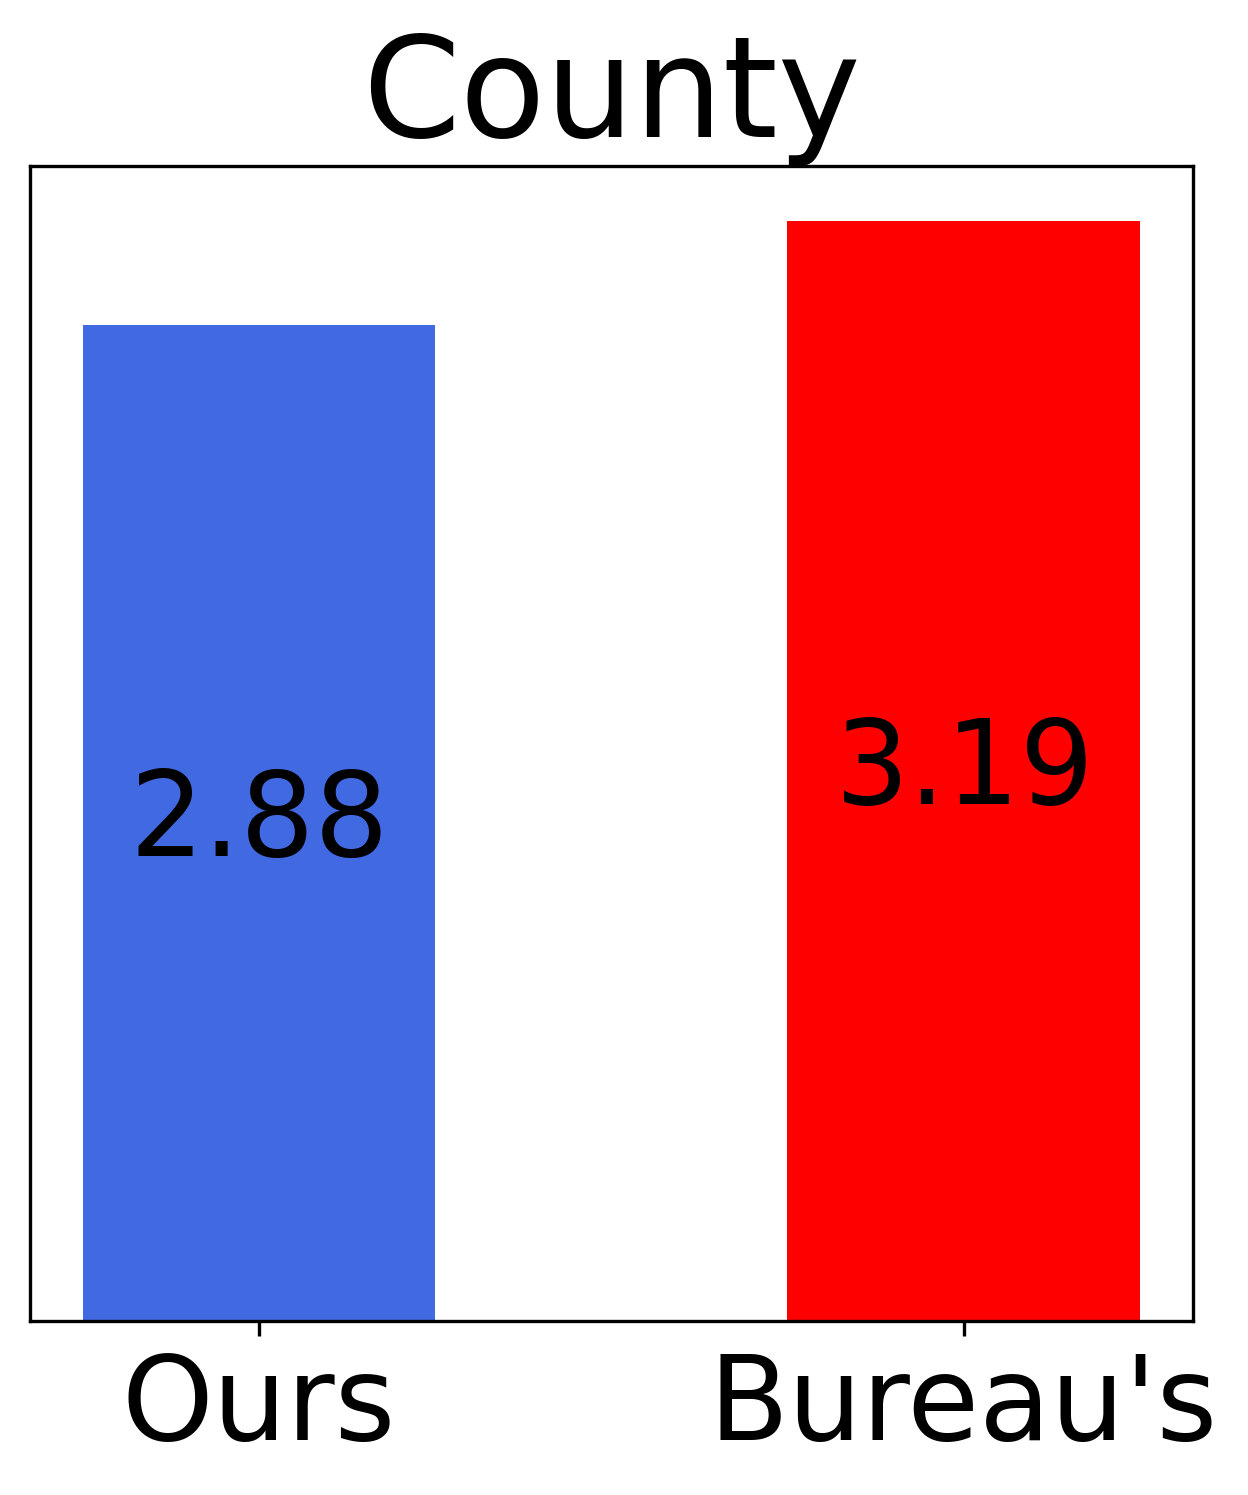

In [10]:
df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_cleaned.csv')
df = df.iloc[0:, 4:]


df_matrix = df.to_numpy()
df_vector = df_matrix.flatten()
print(df_matrix.shape)
print(df_vector.shape)
df_vector = df_vector.tolist()

data = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_privatized_data.csv')

privatized_ans = data['privatized_ans_CLT']
privatized_ans_zCDP = data['privatized_ans_zCDP']

error_CLT = privatized_ans - df_vector[:len(data)]
error_zCDP = privatized_ans_zCDP - df_vector[:len(data)]

list1 = np.abs(error_CLT)
list2 = np.abs(error_zCDP)

mean1 = np.mean(list1)
mean2 = np.mean(list2)
std1 = np.std(list1)
std2 = np.std(list2)

error_kw = {'capsize': 10, 'elinewidth': 2, 'capthick': 2}

# Confidence interval (95%) calculation
# Assuming a normal distribution, the confidence interval can be calculated as 1.96 * std/sqrt(n)
ci1 = 1.96 * (std1/np.sqrt(len(list1)))
ci2 = 1.96 * (std2/np.sqrt(len(list2)))


# Create figure and axis
fig, ax = plt.subplots()
x_positions = [0, 0.2]

# Bar plots
bars1 = ax.bar(x_positions[0], mean1, color='royalblue', error_kw=error_kw, width=0.1)
bars2 = ax.bar(x_positions[1], mean2, color='red', error_kw=error_kw, width=0.1)

# Adding the numbers on top of the bars
ax.bar_label(bars1, fmt='%.2f', label_type='center')
ax.bar_label(bars2, fmt='%.2f', label_type='center')

# Setting the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(['Ours', "Bureau's"])

# Remove Y-axis label and Y-axis ticks
ax.set_yticks([])
ax.set_ylabel('')


# ax.set_ylabel('Mean Absolute Error')
ax.set_title('County')

# Show the plot
plt.savefig("/content/drive/MyDrive/American_Census_Data/Figures_V1/county_level_mae.svg", bbox_inches='tight')
plt.show()

# **After Post-Processing Error and Plot**

In [11]:
df = df.iloc[0:, 4:]



df_matrix = df.to_numpy()
df_vector = df_matrix.flatten()
print(df_matrix.shape)
print(df_vector.shape)
df_vector = df_vector.tolist()



privatized_ans=[]
for i in range(len(df_vector)):
        sigma2_CLT = 13.21
        noise_CLT = sample_dgauss(sigma2_CLT)
        privatized_ans.append(df_vector[i] + noise_CLT)
print(privatized_ans)
#non-negative post-processing
privatized_ans = np.maximum(privatized_ans,np.zeros(len(df_vector)))


privatized_ans = np.array(privatized_ans)
df_vector = np.array(df_vector)
error_CLT = privatized_ans - df_vector
error_CLT2 = np.square(error_CLT)
error_CLT_mean = np.mean(error_CLT2)
print("LS error for CLT is " + str(error_CLT_mean))



privatized_ans_zCDP=[]
for i in range(len(df_vector)):
        sigma2_zCDP = 16.07
        noise_zCDP = sample_dgauss(sigma2_zCDP)
        privatized_ans_zCDP.append(df_vector[i] + noise_zCDP)
print(privatized_ans_zCDP)
#non-negative post-processing
privatized_ans_zCDP = np.maximum(privatized_ans_zCDP,np.zeros(len(df_vector)))


privatized_ans_zCDP = np.array(privatized_ans_zCDP)
df_vector = np.array(df_vector)
error_zCDP = privatized_ans_zCDP - df_vector
error_zCDP2 = np.square(error_zCDP)
error_zCDP_mean = np.mean(error_zCDP2)
print("LS error for z-CDP is " + str(error_zCDP_mean))




(3221, 297)
(956637,)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## **Save**

In [12]:
df_privatized_ans = pd.DataFrame({
    'privatized_ans_CLT': privatized_ans,
    'privatized_ans_zCDP': privatized_ans_zCDP
})

# Save to CSV
csv_path = "/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_post_privatized_data.csv"
df_privatized_ans.to_csv(csv_path, index=False)

# **Plot**

### MSE

(3221, 301)
(969521,)


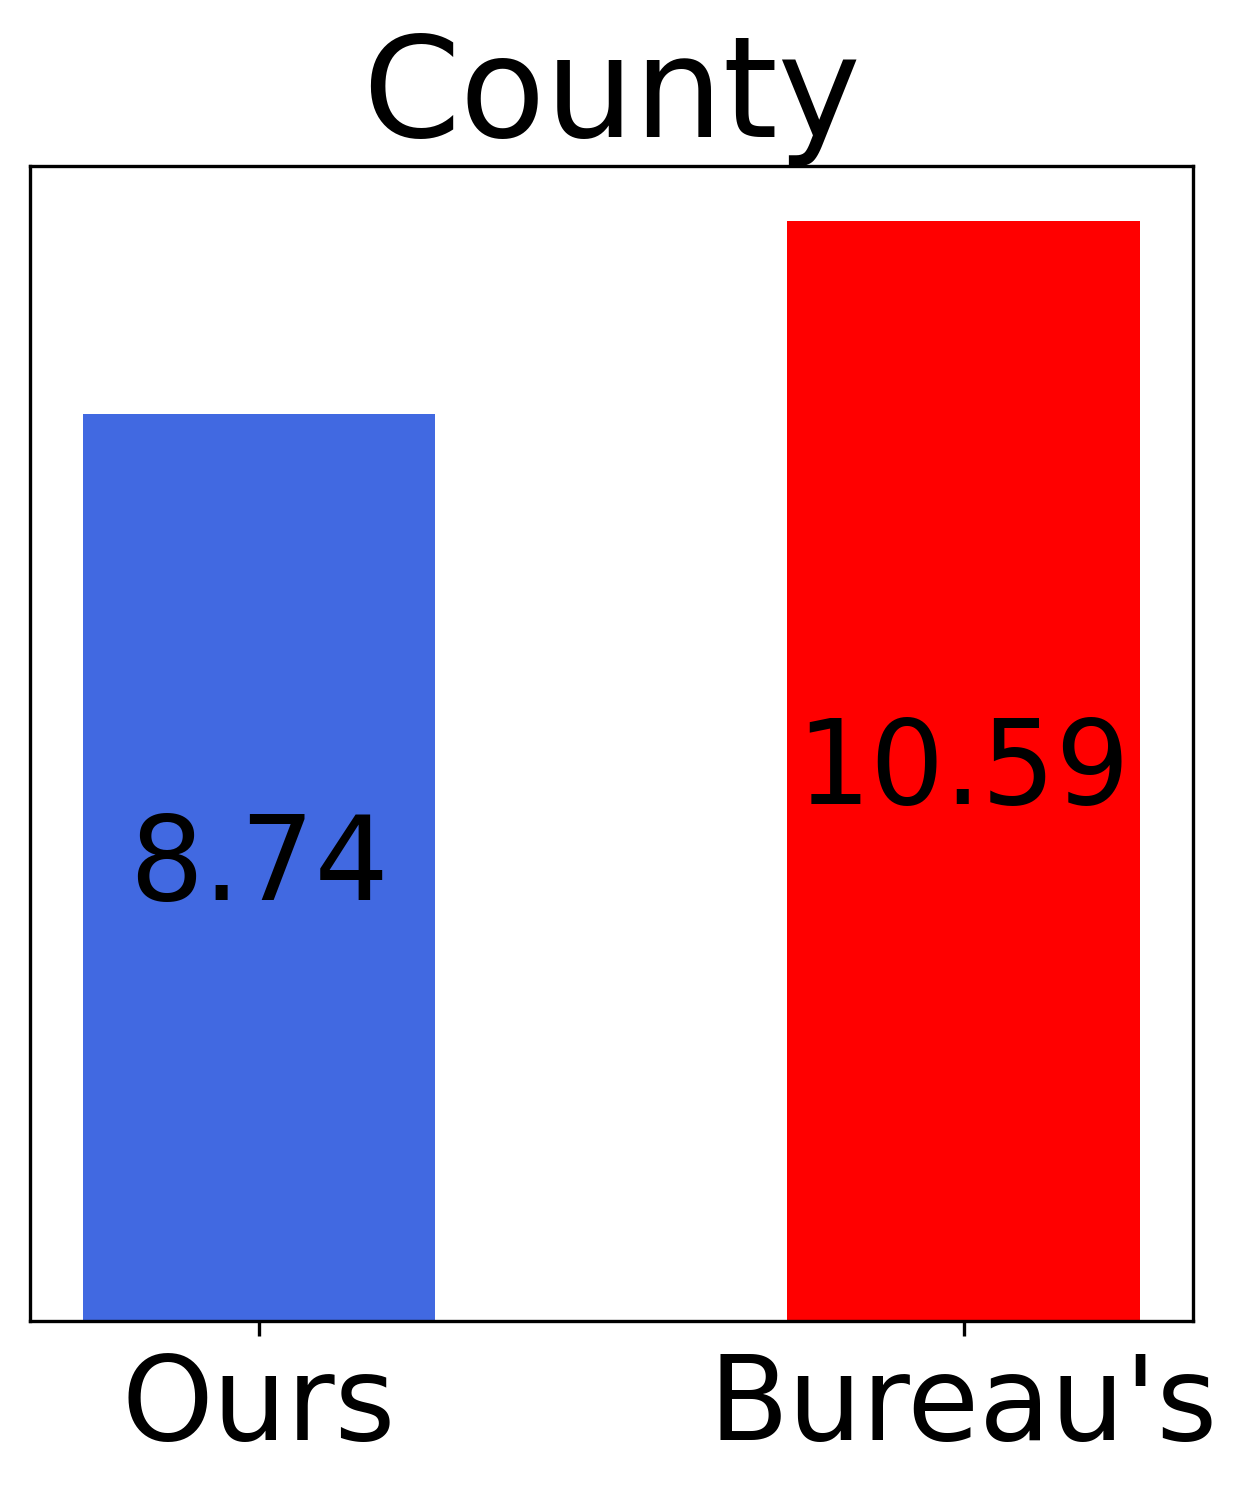

In [13]:
df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_cleaned.csv')
df = df.iloc[0:, 4:]


df_matrix = df.to_numpy()
df_vector = df_matrix.flatten()
print(df_matrix.shape)
print(df_vector.shape)
df_vector = df_vector.tolist()

data = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_privatized_data.csv')

privatized_ans = data['privatized_ans_CLT']
privatized_ans_zCDP = data['privatized_ans_zCDP']

privatized_ans = np.maximum(privatized_ans,np.zeros(len(df_vector)))
privatized_ans_zCDP = np.maximum(privatized_ans_zCDP,np.zeros(len(df_vector)))

error_CLT = privatized_ans - df_vector[:len(data)]
error_zCDP = privatized_ans_zCDP - df_vector[:len(data)]

list1 = np.square(error_CLT)
list2 = np.square(error_zCDP)

mean1 = np.mean(list1)
mean2 = np.mean(list2)
std1 = np.std(list1)
std2 = np.std(list2)

error_kw = {'capsize': 10, 'elinewidth': 2, 'capthick': 2}

# Confidence interval (95%) calculation
# Assuming a normal distribution, the confidence interval can be calculated as 1.96 * std/sqrt(n)
ci1 = 1.96 * (std1/np.sqrt(len(list1)))
ci2 = 1.96 * (std2/np.sqrt(len(list2)))


# Create figure and axis
fig, ax = plt.subplots()
x_positions = [0, 0.2]

# Bar plots
bars1 = ax.bar(x_positions[0], mean1, color='royalblue', error_kw=error_kw, width=0.1)
bars2 = ax.bar(x_positions[1], mean2, color='red', error_kw=error_kw, width=0.1)

# Adding the numbers on top of the bars
ax.bar_label(bars1, fmt='%.2f', label_type='center')
ax.bar_label(bars2, fmt='%.2f', label_type='center')

# Setting the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(['Ours', "Bureau's"])

# Remove Y-axis label and Y-axis ticks
ax.set_yticks([])
ax.set_ylabel('')


# ax.set_ylabel('Mean Squared Error')
ax.set_title('County')

# Show the plot
plt.savefig("/content/drive/MyDrive/American_Census_Data/Figures_V1/county_level_mse_post.svg", bbox_inches='tight')
plt.show()

### MAE

(3221, 301)
(969521,)


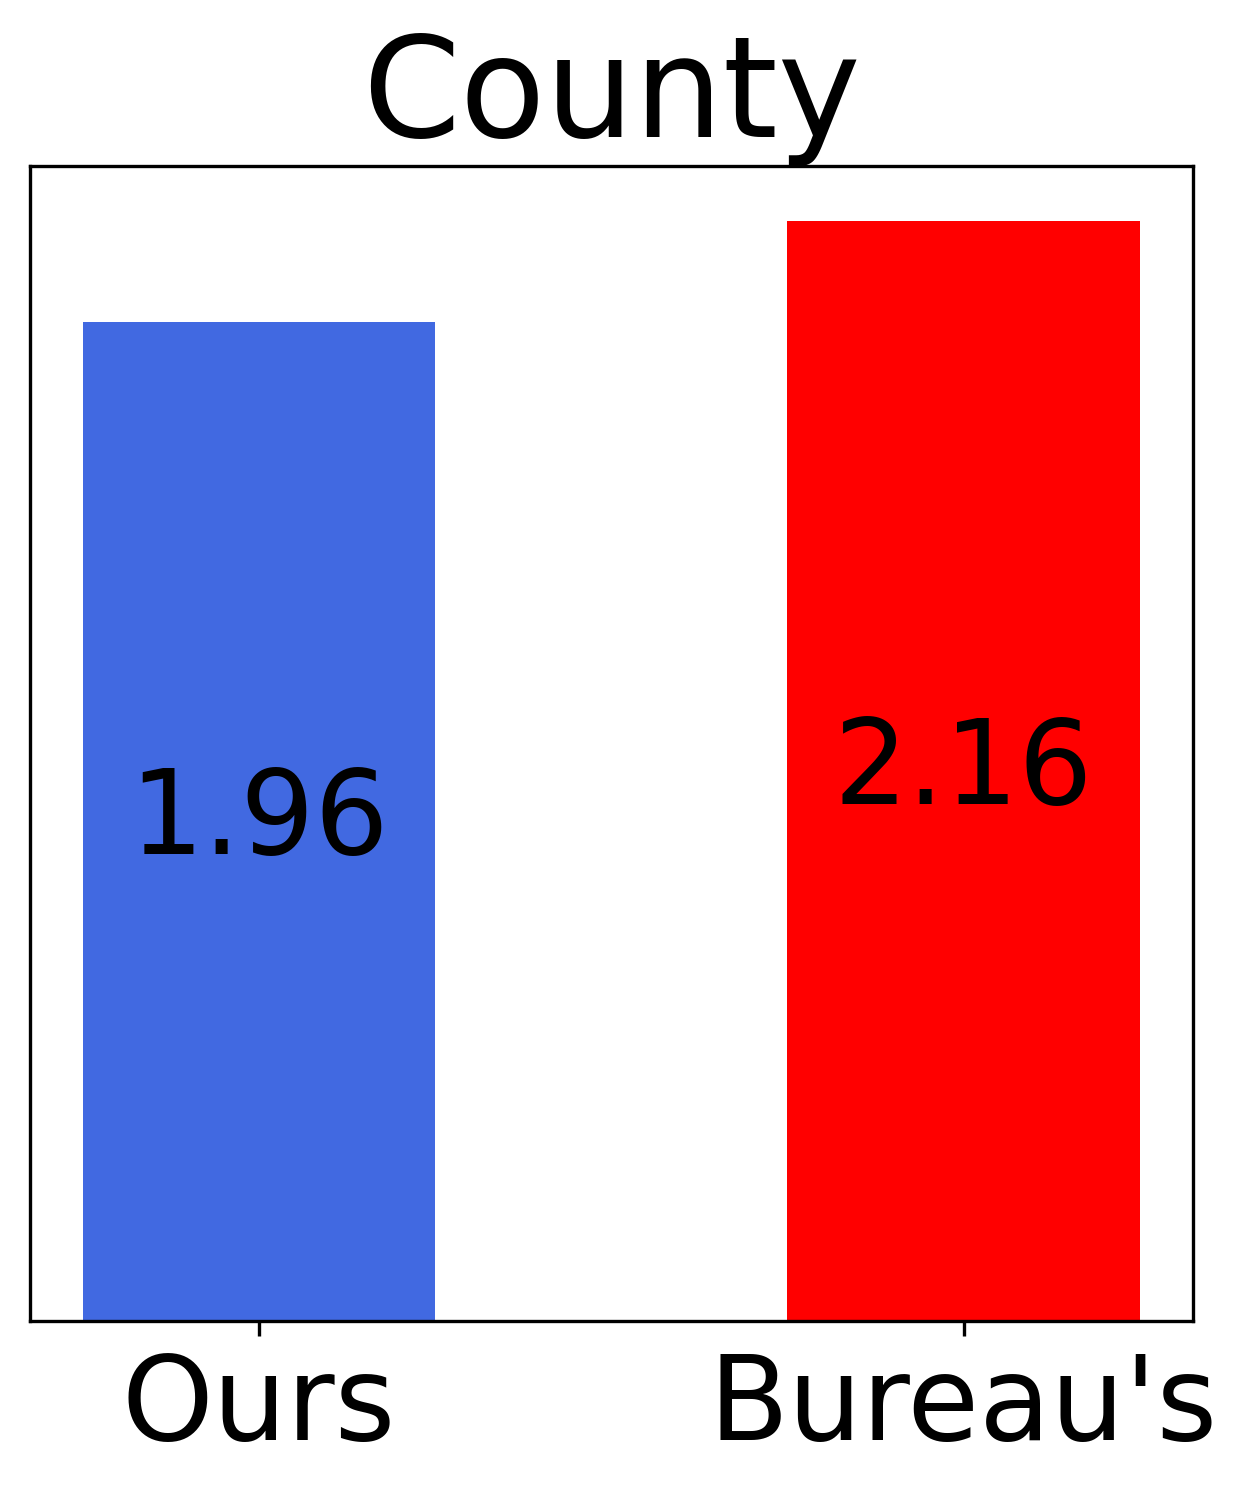

In [14]:
df = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_cleaned.csv')
df = df.iloc[0:, 4:]


df_matrix = df.to_numpy()
df_vector = df_matrix.flatten()
print(df_matrix.shape)
print(df_vector.shape)
df_vector = df_vector.tolist()

data = pd.read_csv(r'/content/drive/MyDrive/American_Census_Data/nhgis_ppdd_20210608_county/nhgis_ppdd_20210608_county_privatized_data.csv')

privatized_ans = data['privatized_ans_CLT']
privatized_ans_zCDP = data['privatized_ans_zCDP']

privatized_ans = np.maximum(privatized_ans,np.zeros(len(df_vector)))
privatized_ans_zCDP = np.maximum(privatized_ans_zCDP,np.zeros(len(df_vector)))

error_CLT = privatized_ans - df_vector[:len(data)]
error_zCDP = privatized_ans_zCDP - df_vector[:len(data)]

list1 = np.abs(error_CLT)
list2 = np.abs(error_zCDP)

mean1 = np.mean(list1)
mean2 = np.mean(list2)
std1 = np.std(list1)
std2 = np.std(list2)

error_kw = {'capsize': 10, 'elinewidth': 2, 'capthick': 2}

# Confidence interval (95%) calculation
# Assuming a normal distribution, the confidence interval can be calculated as 1.96 * std/sqrt(n)
ci1 = 1.96 * (std1/np.sqrt(len(list1)))
ci2 = 1.96 * (std2/np.sqrt(len(list2)))


# Create figure and axis
fig, ax = plt.subplots()
x_positions = [0, 0.2]

# Bar plots
bars1 = ax.bar(x_positions[0], mean1, color='royalblue', error_kw=error_kw, width=0.1)
bars2 = ax.bar(x_positions[1], mean2, color='red', error_kw=error_kw, width=0.1)

# Adding the numbers on top of the bars
ax.bar_label(bars1, fmt='%.2f', label_type='center')
ax.bar_label(bars2, fmt='%.2f', label_type='center')

# Setting the x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(['Ours', "Bureau's"])

# Remove Y-axis label and Y-axis ticks
ax.set_yticks([])
ax.set_ylabel('')


# ax.set_ylabel('Mean Absolute Error')
ax.set_title('County')

# Show the plot
plt.savefig("/content/drive/MyDrive/American_Census_Data/Figures_V1/county_level_mae_post.svg", bbox_inches='tight')
plt.show()